In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import hdbscan
from scipy.optimize import linear_sum_assignment
from sklearn.neighbors import KDTree

In [2]:
def bit_error_rate(y_true, y_pred):    
    true = ''.join([format(x, '04b') for x in y_true])
    pred = ''.join([format(x, '04b') for x in y_pred])
    ber = np.sum([1 for i in range(len(true)) if true[i] != pred[i]]) / len(true)
    return ber

def adjust_labels(y_true, y_pred):
    # Crear la matriz de costos
    cost_matrix = np.zeros((max(y_true) + 1, max(y_pred) + 1), dtype=int)
    for i in range(len(y_true)):
        cost_matrix[y_true[i], y_pred[i]] += 1
    
    # Encontrar la mejor correspondencia
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Ajustar las etiquetas predichas
    y_pred_adjusted = np.array([mapping[label] for label in y_pred])
    return y_pred_adjusted

def remaining_labels_kdt(labels, X, predict_mode='nearest', radius=1.0, k=3):    
    new_labels = np.copy(labels)
    noise = X[new_labels == -1]
    noise_idx = np.where(new_labels == -1)[0]
    non_noise = X[new_labels != -1]
    non_noise_idx = np.where(new_labels != -1)[0]
    if len(noise) == 0:
        return new_labels
    kdt = KDTree(non_noise)
    if predict_mode == 'nearest':
        _, ind = kdt.query(noise, k=k)
    elif predict_mode == 'radius':
        ind = kdt.query_radius(noise, r=radius)
    else:
        print('Invalid prediction mode.')
        return None
    for i in range(len(noise)):
        if ind[i].size == 0: # No neighbors found
            label = 0
        else:
            neighbors_idx = new_labels[non_noise_idx[ind[i]]]
            label = np.argmax(np.bincount(neighbors_idx))
        new_labels[noise_idx[i]] = label
    return new_labels

def fit_curve(step, x, y, deg=2):
    p = np.polyfit(x, y, deg)
    z = np.poly1d(p)
    curve = z(step)
    return curve

def demapper_sym(symbols_I, symbols_Q, threshold=2.0):
    symbols = np.zeros(len(symbols_I), dtype=int)
    for i in range(len(symbols_I)):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: # -3 + 3j
            symbols[i] = 0
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: # -3 + 1j
            symbols[i] = 1
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: # -3 - 1j
            symbols[i] = 3
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: # -3 - 3j
            symbols[i] = 2
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: # -1 + 3j
            symbols[i] = 4
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: # -1 + 1j
            symbols[i] = 5
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: # -1 - 1j
            symbols[i] = 7
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: # -1 - 3j
            symbols[i] = 6
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: # 1 + 3j
            symbols[i] = 12
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: # 1 + 1j
            symbols[i] = 13
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: # 1 - 1j
            symbols[i] = 15
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: # 1 - 3j
            symbols[i] = 14
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: # 3 + 3j
            symbols[i] = 8
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: # 3 + 1j
            symbols[i] = 9
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: # 3 - 1j
            symbols[i] = 11
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: # 3 - 3j
            symbols[i] = 10
        else:
            symbols[i] = -1
    return symbols

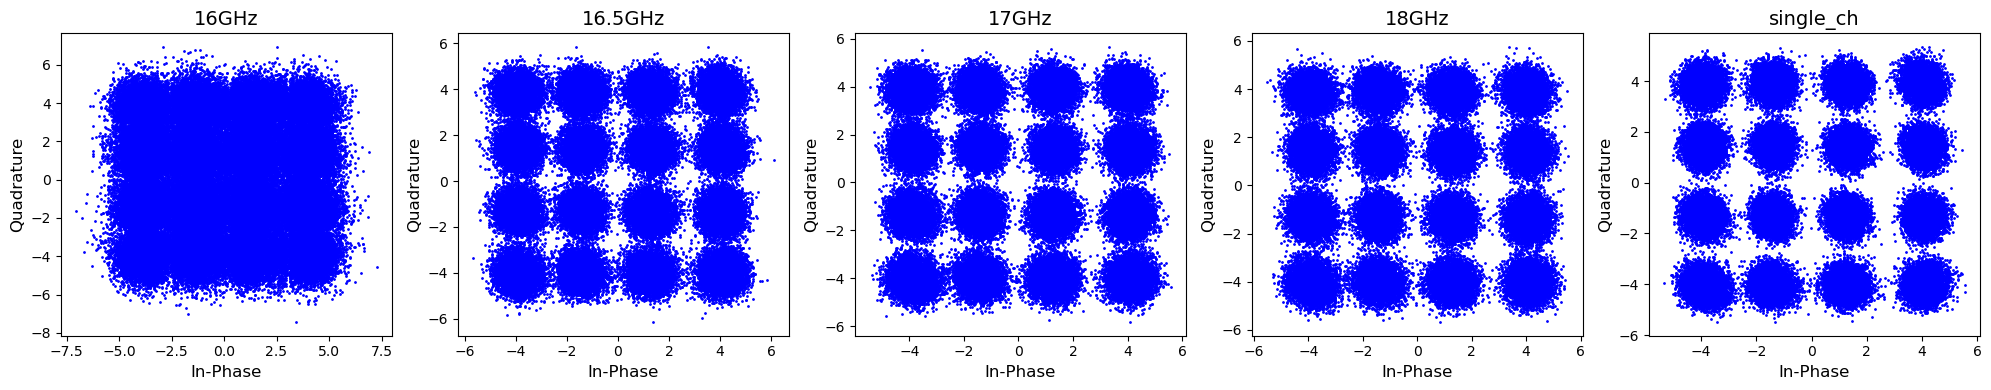

In [3]:
spacing = ["16GHz", "16.5GHz", "17GHz", "18GHz", "single_ch"]

X = []
y = []

fig, axs = plt.subplots(1, len(spacing), figsize=(20, 4))

for it, item in enumerate(spacing):
    data = np.loadtxt(f"250km/{item}_250km.csv", delimiter=",", skiprows=1)

    # Separe the data in In-Phase and Quadrature from 0 and 1 columns
    I = data[:, 0]
    Q = data[:, 1]
    iq_sym = np.array([I, Q]).T
    X.append(iq_sym)

    # Create the labels from 2 column
    y.append(data[:, 2])

    # Plot the data
    axs[it].scatter(I, Q, s=1, c="b")
    axs[it].set_title(item, fontsize=14)
    axs[it].set_xlabel("In-Phase", fontsize=12)
    axs[it].set_ylabel("Quadrature", fontsize=12)

plt.tight_layout()
plt.show()

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.uint8)

In [4]:
test_size = 0.7
random_state = 42

## Conventional Demodulation

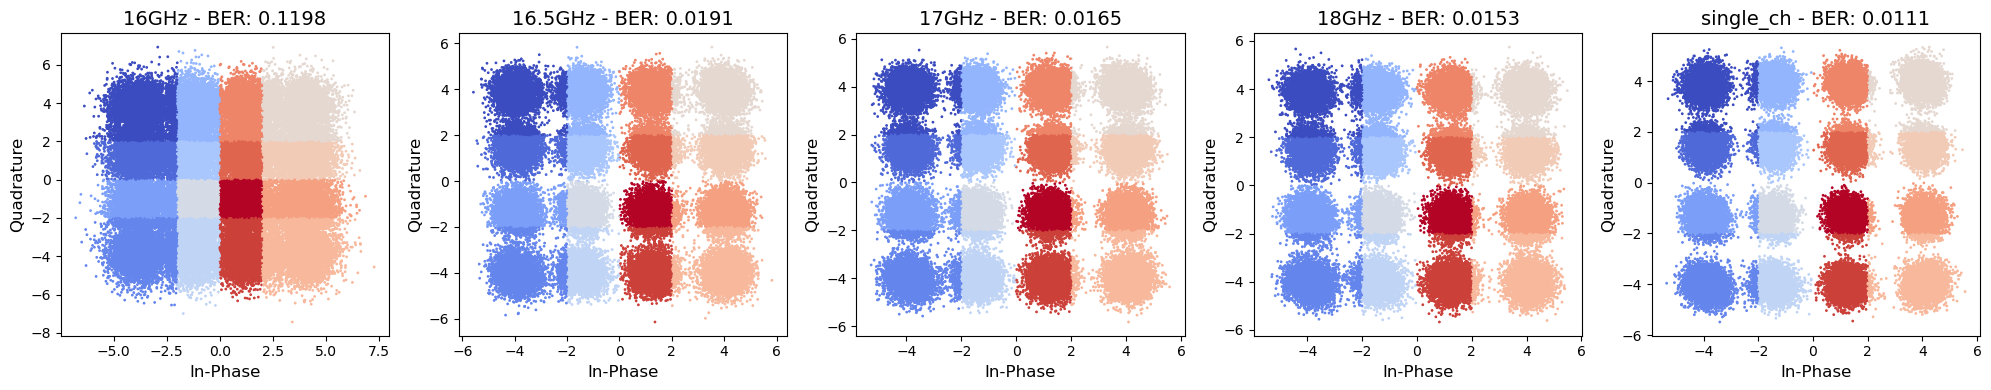

In [5]:
ber_conv = []

fig, axs = plt.subplots(1, len(spacing), figsize=(20, 4))

for it, item in enumerate(spacing):
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=test_size, random_state=random_state)

    mod_syms = demapper_sym(X_test[:, 0], X_test[:, 1])
    ber = bit_error_rate(y_test, mod_syms)
    ber_conv.append(ber)

    # Plot the data
    axs[it].scatter(X_test[:, 0], X_test[:, 1], s=1, c=mod_syms, cmap="coolwarm")
    axs[it].set_title(f"{item} - BER: {ber:.4f}", fontsize=14)
    axs[it].set_xlabel("In-Phase", fontsize=12)
    axs[it].set_ylabel("Quadrature", fontsize=12)

plt.tight_layout()
plt.show()

ber_conv = np.array(np.log10(ber_conv))

## Demodulation using DT

Best parameters for 16GHz: {'max_depth': 6}
Best parameters for 16.5GHz: {'max_depth': 6}
Best parameters for 17GHz: {'max_depth': 6}
Best parameters for 18GHz: {'max_depth': 6}
Best parameters for single_ch: {'max_depth': 6}


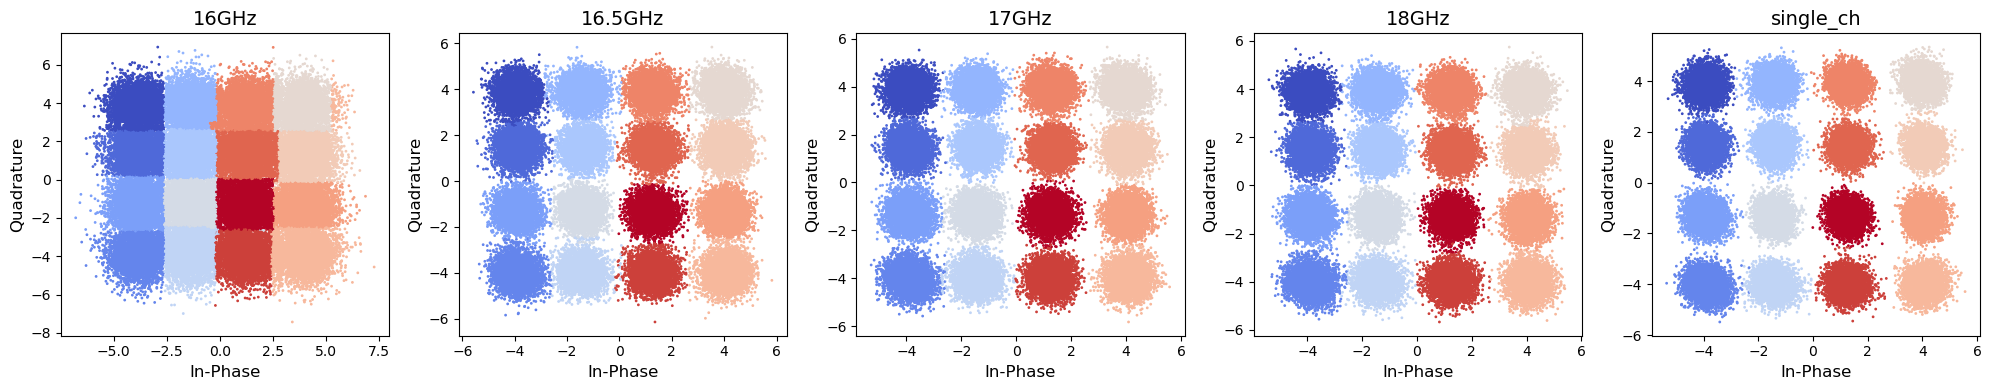

In [6]:
params = {
    "max_depth": [3, 6, 9, 12, 15, None],
}

ber_dt = []

fig, axs = plt.subplots(1, len(spacing), figsize=(20, 4))

for it, item in enumerate(spacing):
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=test_size, random_state=random_state)

    clf = DecisionTreeClassifier(random_state=random_state)
    grid = GridSearchCV(clf, params, cv=5, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    # Show the best parameters
    print(f"Best parameters for {item}: {grid.best_params_}")

    ber = bit_error_rate(y_test, y_pred)
    ber_dt.append(ber)

    # Plot the data
    axs[it].scatter(X_test[:, 0], X_test[:, 1], s=1, c=y_pred, cmap="coolwarm")
    axs[it].set_title(item, fontsize=14)
    axs[it].set_xlabel("In-Phase", fontsize=12)
    axs[it].set_ylabel("Quadrature", fontsize=12)

plt.tight_layout()
plt.show()

ber_dt = np.array(np.log10(ber_dt))

## Demodulatio using HDBSCAN + K-D Tree

Number of clusters for 16GHz: 16
Number of clusters for 16.5GHz: 16
Number of clusters for 17GHz: 16
Number of clusters for 18GHz: 16
Number of clusters for single_ch: 16


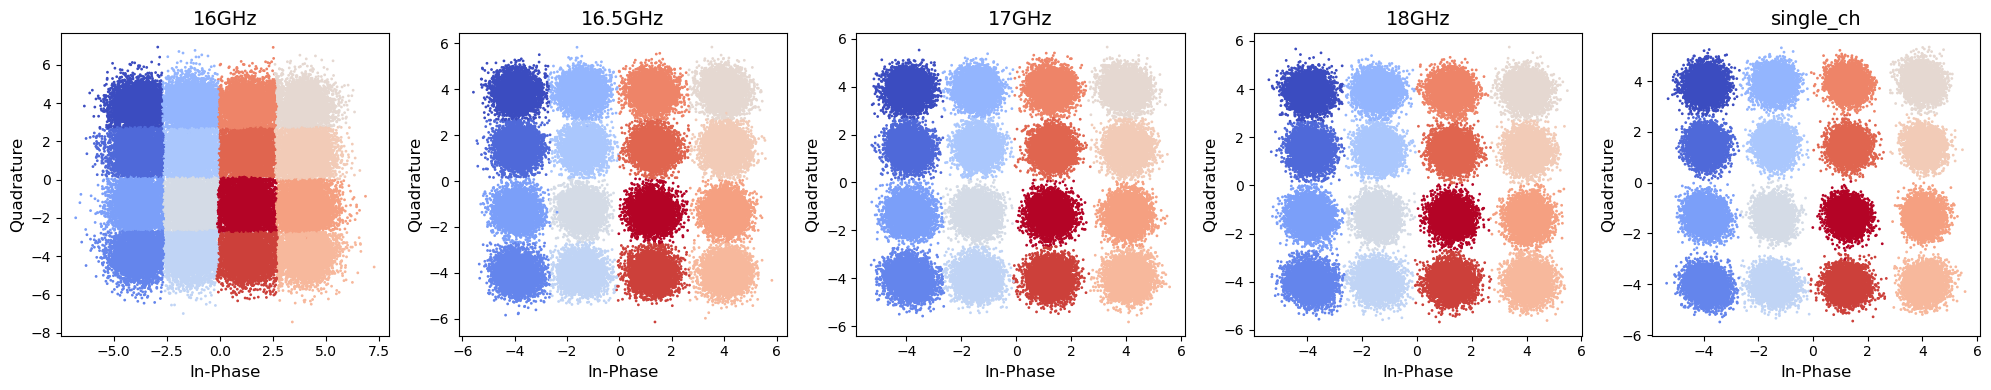

In [7]:
ber_hdb = []

fig, axs = plt.subplots(1, len(spacing), figsize=(20, 4))

for it, item in enumerate(spacing):
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=test_size, random_state=random_state)

    hdb = hdbscan.HDBSCAN(min_cluster_size=675)
    y_pred = hdb.fit_predict(X_test)

    labels = remaining_labels_kdt(y_pred, X_test, predict_mode='nearest', k=21)

    y_pred_adjusted = adjust_labels(y_test, labels)

    print(f"Number of clusters for {item}: {len(np.unique(y_pred_adjusted))}")

    ber = bit_error_rate(y_test, y_pred_adjusted)
    ber_hdb.append(ber)

    # Plot the data
    axs[it].scatter(X_test[:, 0], X_test[:, 1], s=1, c=y_pred_adjusted, cmap="coolwarm")
    axs[it].set_title(item, fontsize=14)
    axs[it].set_xlabel("In-Phase", fontsize=12)
    axs[it].set_ylabel("Quadrature", fontsize=12)

plt.tight_layout()
plt.show()

ber_hdb = np.array(np.log10(ber_hdb))

## Demodulation using KNN

Best parameters for 16GHz: {'n_neighbors': 21}
Best parameters for 16.5GHz: {'n_neighbors': 21}
Best parameters for 17GHz: {'n_neighbors': 21}
Best parameters for 18GHz: {'n_neighbors': 21}
Best parameters for single_ch: {'n_neighbors': 9}


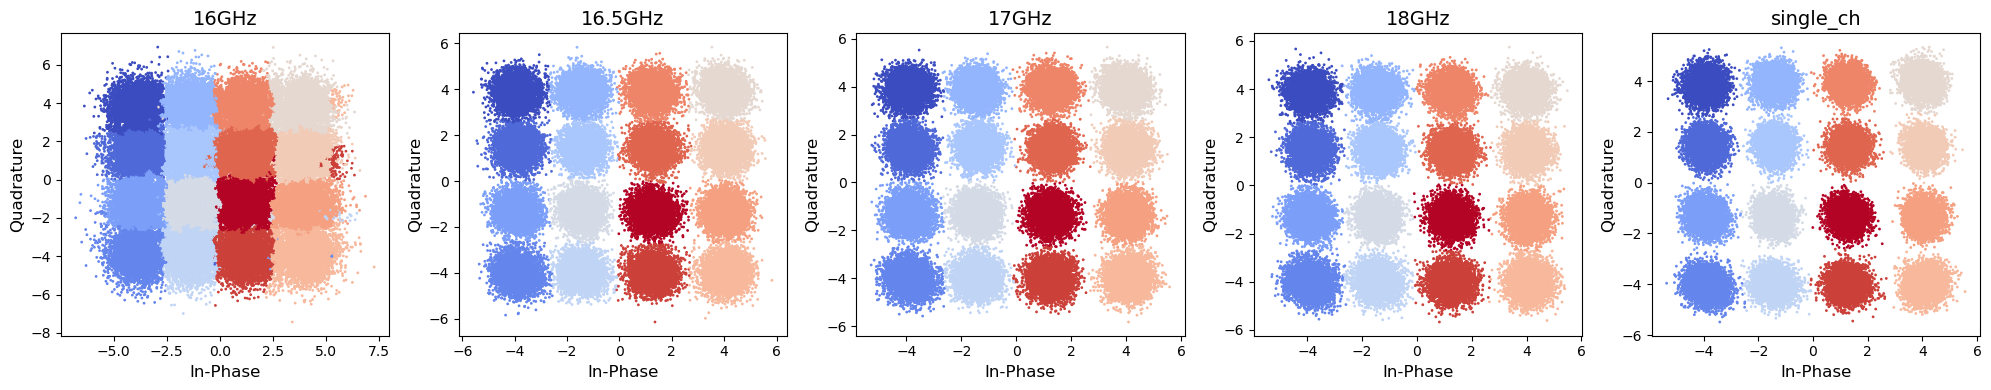

In [13]:
params = {
    "n_neighbors": [7, 9, 11, 15, 21],
}

ber_knn = []

fig, axs = plt.subplots(1, len(spacing), figsize=(20, 4))

for it, item in enumerate(spacing):
    X_train, X_test, y_train, y_test = train_test_split(X[it], y[it], test_size=test_size, random_state=random_state)

    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, params, cv=5, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    # Show the best parameters
    print(f"Best parameters for {item}: {grid.best_params_}")

    ber = bit_error_rate(y_test, y_pred)
    ber_knn.append(ber)

    # Plot the data
    axs[it].scatter(X_test[:, 0], X_test[:, 1], s=1, c=y_pred, cmap="coolwarm")
    axs[it].set_title(item, fontsize=14)
    axs[it].set_xlabel("In-Phase", fontsize=12)
    axs[it].set_ylabel("Quadrature", fontsize=12)

plt.tight_layout()
plt.show()

ber_knn = np.array(np.log10(ber_knn))

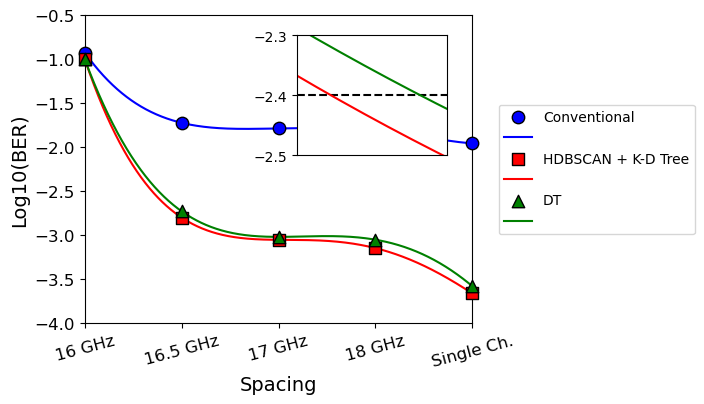

In [60]:
deg = 4
x_step = np.linspace(0, 4, 1000)

plt.figure(figsize=(5, 4))

plt.scatter(range(5), ber_conv, s=80, c="b", marker="o", edgecolors="k", label="Conventional", zorder=3, clip_on=False)
plt.plot(x_step, fit_curve(x_step, range(5), ber_conv, deg), c="b", label=" ")

plt.scatter(range(5), ber_hdb, s=80, c="r", marker="s", edgecolors="k", label="HDBSCAN + K-D Tree", zorder=3, clip_on=False)
plt.plot(x_step, fit_curve(x_step, range(5), ber_hdb, deg), c="r", label=" ")

plt.scatter(range(5), ber_dt, s=80, c="g", marker="^", edgecolors="k", label="DT", zorder=3, clip_on=False)
plt.plot(x_step, fit_curve(x_step, range(5), ber_dt, deg), c="g", label=" ")

# plt.scatter(range(5), ber_knn, s=80, c="m", marker="v", edgecolors="k", label="KNN", zorder=3, clip_on=False)
# plt.plot(x_step, fit_curve(x_step, range(5), ber_knn, deg), c="m", label=" ")

plt.xlabel("Spacing", fontsize=14)
plt.ylabel("Log10(BER)", fontsize=14)
plt.xlim(0, 4)
plt.ylim(-4, -0.5)

plt.xticks(range(5), ["16 GHz", "16.5 GHz", "17 GHz", "18 GHz", "Single Ch."], fontsize=12, rotation=15)
plt.yticks(np.arange(-4, -0.4, 0.5), fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=10)

# Create zoom graph
plt.axes([0.55, 0.53, 0.3, 0.3])
plt.hlines(-2.4, 0.4, 0.8, colors="k", linestyles="--")
plt.plot(x_step, fit_curve(x_step, range(5), ber_conv, deg), c="b", label=" ")
plt.plot(x_step, fit_curve(x_step, range(5), ber_hdb, deg), c="r", label=" ")
plt.plot(x_step, fit_curve(x_step, range(5), ber_dt, deg), c="g", label=" ")
plt.xlim(0.6, 0.7)
plt.ylim(-2.5, -2.3)
plt.xticks(())

plt.show()